In [274]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import pipeline
import json


def read_annotation_file(path):
    '''This creates a dictionary where the first key is the sequence id,
    and the second key is the frame id, which contains a list of the 
    annotation points as lists of floating numbers.
    For example sequence #1 shown above contains 3 objects, which are visible in both frames #1 and #3.'''
    with open(path) as annotation_file:
        annotation_list = json.load(annotation_file)
    # Transform list of annotations into dictionary
    annotation_dict = {}
    for annotation in annotation_list:
        sequence_id = annotation['sequence_id']
        if sequence_id not in annotation_dict:
            annotation_dict[sequence_id] = {}
        annotation_dict[sequence_id][annotation['frame']] = annotation['object_coords']
    return annotation_dict


def get_targets(dataset, seqid):
    '''Returns array of n_objects x n_frames x coords'''
    return np.array([dataset[seqid][frame] for frame in dataset[seqid]]).swapaxes(0, 1)


def draw_circle(ax, r, c, radius, color):
    circle = plt.Circle((c, r), radius, color=color, fill=False)
    ax.add_artist(circle)

    
def draw_target(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='r')
    
    
def draw_prediction(ax, r, c):
    draw_circle(ax, r, c, radius=10, color='g')


pipeline.PATH = '../spotGEO'
pipeline.DO_TRAIN = True
pipeline.MODEL_PATH= "../mainfilter-2020_06_18.h5"

seqid = 59
output = pipeline.process(seqid)

dataset = read_annotation_file('../spotGEO/train_anno.json')

targets = get_targets(dataset, seqid)

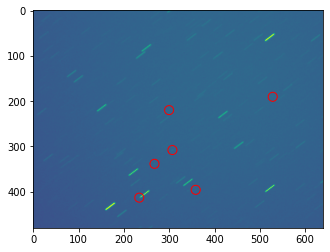

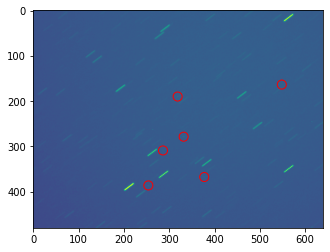

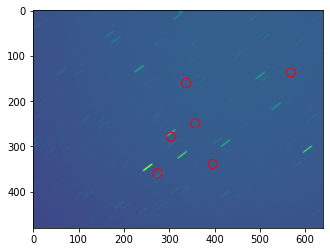

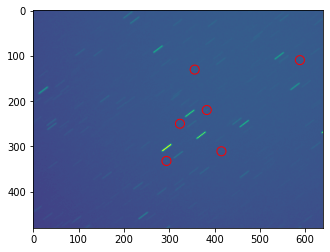

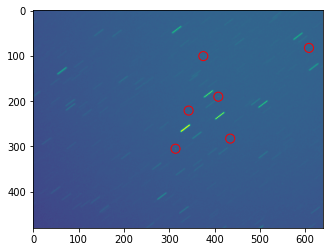

In [275]:
%matplotlib inline

for frameid in range(0, 5):
    frame = pipeline.intermediate["frames"][frameid]    
    plt.imshow(frame, vmin=0, vmax=1)
    for x, y in targets[:, frameid]:
        draw_target(plt.gcf().gca(), y, x)
    plt.show()

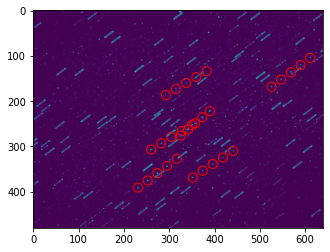

In [276]:
registered = [pipeline.intermediate["registered"][frameid] for frameid in range(0, 5)]
    
plt.imshow( np.max(registered, axis=0) , vmin=0, vmax=1)

for frameid in range(0, 5):
    Z = transform.matrix_transform(targets[:, frameid], pipeline.intermediate["Ts"][frameid])
    for x, y in Z:
        draw_target(plt.gcf().gca(), y, x)
plt.show()

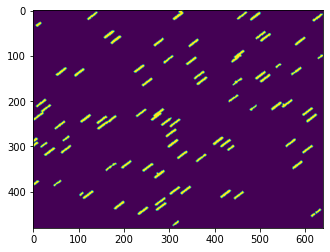

In [277]:
from skimage import measure

Istars = np.max(registered, axis=0)
Istars = exposure.rescale_intensity(Istars)
Istars = Istars > 0.1

Ilabels = morphology.label(Istars)

regions = measure.regionprops(Ilabels)

labels = [region.label for region in regions if region.area > 25]

mask = np.zeros(Ilabels.shape, dtype='bool')

for label in labels:
    mask[Ilabels == label] = True

mask = morphology.dilation(mask)

plt.imshow(mask)
plt.show()

In [278]:
def star_mask(registered):
    Istars = np.max(registered, axis=0)
    Istars = exposure.rescale_intensity(Istars)
    Istars = Istars > 0.1

    Ilabels = morphology.label(Istars)

    regions = measure.regionprops(Ilabels)

    labels = [region.label for region in regions if region.area > 25]

    mask = np.zeros(Ilabels.shape, dtype='bool')

    for label in labels:
        mask[Ilabels == label] = True

    mask = morphology.dilation(mask)
    
    return mask

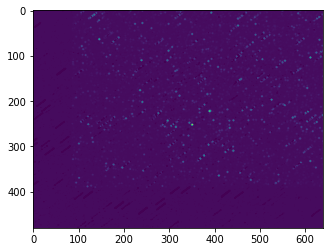

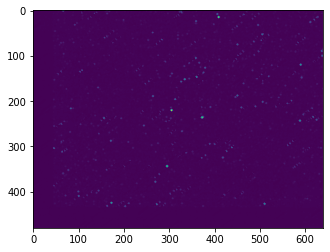

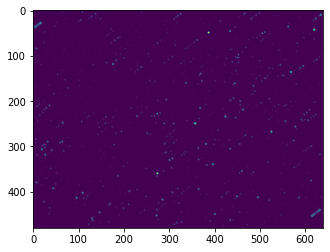

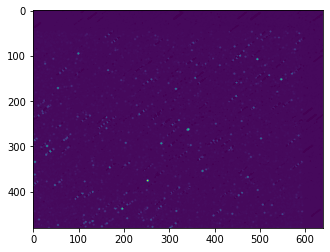

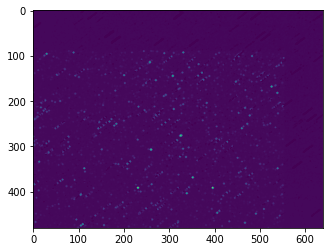

In [279]:
registered = pipeline.intermediate["registered"]

# Compute background subtraction                                                                                      
Idiffs = []                                                                                                           
                                                                                                                          
for frameid in range(0, 5):                                                                                           
    Ibase = np.max([registered[i] for i in range(0, 5) if i != frameid], axis=0)                                   
    # Idiff = filters.gaussian(registered[frameid]) - Ibase
    Idiff = registered[frameid] - Ibase
    # Idiff = morphology.white_tophat(Idiff, selem=morphology.square(3))
    Idiff = exposure.rescale_intensity(Idiff)
    Idiff = Idiff
    Idiffs.append(Idiff)
    
    plt.imshow( morphology.dilation(Idiff), vmin=0, vmax=1)
    plt.show()

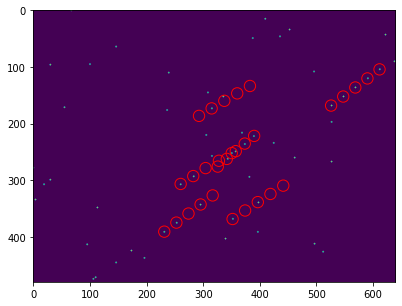

In [283]:
from skimage import exposure

registered = pipeline.intermediate["registered"]

# Compute background subtraction                                                                                      
Idiffs = []                                                                                                           
                                                                                                                          
for frameid in range(0, 5):                                                                                           
    Ibase = np.max([registered[i] for i in range(0, 5) if i != frameid], axis=0)                                    
    # Idiff = filters.gaussian(registered[frameid]) - Ibase
    Idiff = registered[frameid] - Ibase
    Idiff = morphology.white_tophat(Idiff, selem=morphology.square(3))
    
    Idiff = Idiff*(1-mask)
    Idiff = exposure.rescale_intensity(Idiff)

    Idiffs.append(Idiff)

Iproposals = []

for frameid in range(0, 5):
    Iproposal = morphology.h_maxima(Idiffs[frameid], 0.5)
    Iproposals.append(Iproposal)

Iout = morphology.dilation(np.max(Iproposals, axis=0))
plt.figure(figsize=(15, 5))
plt.imshow(Iout)
for frameid in range(0, 5):
    Z = transform.matrix_transform(targets[:, frameid], pipeline.intermediate["Ts"][frameid])
    for x, y in Z:
        draw_target(plt.gcf().gca(), y, x)
plt.show()

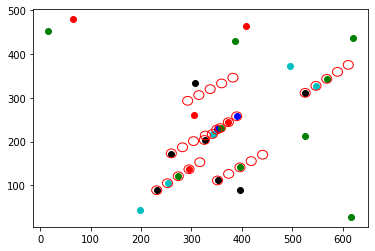

In [281]:
from skimage import transform

colors = ['b', 'r', 'g', 'c', 'k']

for frameid in range(0, 5):
    frame = pipeline.intermediate["registered"][frameid]    
    coords = pipeline.intermediate["f_coords"][frameid]
         
    Z = transform.matrix_transform(targets[:, frameid], pipeline.intermediate["Ts"][frameid])
    
    plt.scatter(coords[:, 0], 480 - coords[:, 1], c=colors[frameid])
    
    for x, y in Z:
        draw_target(plt.gcf().gca(), 480 - y, x)
plt.show()